In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import pymongo
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["papers"]
paras = db["paragraphs"]

In [3]:
classified_paras = list(paras.find({'manually_classified': True}))

In [4]:
X_tensor = torch.tensor([para['matbert_uncased_cls'] for para in classified_paras])
y_tensor = torch.tensor([1 if para['synthesis'] else 0 for para in classified_paras])

In [5]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
len(dataset)

999

In [7]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=768):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Two output classes
    
    def forward(self, x):
        return self.linear(x)


In [ ]:
model = LogisticRegressionModel()
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.005) 

num_epochs = 110
train_losses = []
val_losses = []

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze() 
            loss = criterion(outputs, labels.float()) 
            total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    val_loss = evaluate(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)


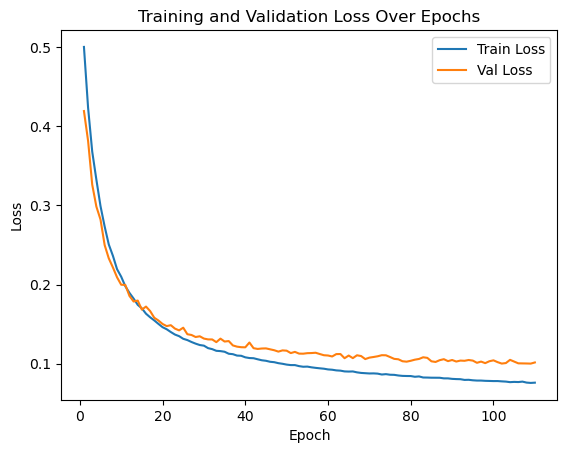

In [14]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [15]:
def evaluate_metrics(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()  # Ensure shape compatibility
            probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = (probabilities > 0.5).long()  # Convert to binary predictions
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    
    # Compute precision, recall, accuracy
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Total Positives: {tp + fn}")
    print(f"Total Negatives: {tn + fp}")
    print('----------------------')
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f'F1 Score: {f1:.4f}')
    print(f"Accuracy: {accuracy:.4f}")    


In [16]:
evaluate_metrics(val_loader)

Total Positives: 40
Total Negatives: 160
----------------------
True Positives: 38
False Positives: 3
True Negatives: 157
False Negatives: 2
Precision: 0.9268
Recall: 0.9500
F1 Score: 0.9383
Accuracy: 0.9750


In [ ]:
#torch.save(model.state_dict(), '../models/binary_synthesis_classifier_cls.pth')